# Exercise 2: Seismograms and spectral analysis

**Motivation**:
 * get practical
 * extract (some) information from seismograms (their spectrum)

**Purpose of this notebook:**
 * load openly accessible seismograms
 * filter by frequency content & investigate spectrum
 * Site characterization/amplification for microzonation
     * compare spectra of one event at two stations
     * investigate spectrum of longer seismograms and use H/V ratio
 * Estimate event parameters
     * fit Brune source spectrum to spectrum of P/S phase
     * seismic moment $M_0$, moment magnitude $M_w$, and corner frequency $f_c$


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Filtering:-Isolating-frequency-content" data-toc-modified-id="Filtering:-Isolating-frequency-content-1">Filtering: Isolating frequency content</a></span></li><li><span><a href="#Get-your-own-seismograms-(for-a-specific-event)" data-toc-modified-id="Get-your-own-seismograms-(for-a-specific-event)-2">Get your own seismograms (for a specific event)</a></span></li><li><span><a href="#Site-characterization" data-toc-modified-id="Site-characterization-3">Site characterization</a></span><ul class="toc-item"><li><span><a href="#Spectral-amplification-during-an-event" data-toc-modified-id="Spectral-amplification-during-an-event-3.1">Spectral amplification during an event</a></span></li><li><span><a href="#H/V-ratio" data-toc-modified-id="H/V-ratio-3.2">H/V ratio</a></span><ul class="toc-item"><li><span><a href="#Using-longer-seismograms" data-toc-modified-id="Using-longer-seismograms-3.2.1">Using longer seismograms</a></span></li><li><span><a href="#Spectrum-of-long-seismograms" data-toc-modified-id="Spectrum-of-long-seismograms-3.2.2">Spectrum of long seismograms</a></span></li><li><span><a href="#Obtain-H/V-ratio" data-toc-modified-id="Obtain-H/V-ratio-3.2.3">Obtain H/V ratio</a></span></li></ul></li></ul></li><li><span><a href="#Estimating-seismic-moment,-magnitude,-and-other-source-parameters" data-toc-modified-id="Estimating-seismic-moment,-magnitude,-and-other-source-parameters-4">Estimating seismic moment, magnitude, and other source parameters</a></span></li></ul></div>

In [81]:
# Prepare: load packages, set some basic options  
%matplotlib inline

# Standard libraries
import os
import numpy as np
import scipy

# Plotting library
import matplotlib
import matplotlib.pylab as plt
import ipywidgets

# Seismological tools
import obspy
from obspy.signal.invsim import cosine_taper 
from obspy.clients.fdsn import Client, RoutingClient
from obspy.core import UTCDateTime

# Set up plotting
# plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100

if not os.path.exists('data'):
    os.mkdir('data')  # we need it for locally caching seismogram streams

## Filtering: Isolating frequency content

Before working with the spectrum, let's explore the different frequency content.

In [82]:
# Cell 2 - filter types

def plot_filter_signal(tr_types, seistype, tslice, freq_range, max_freq, logfx, logfy, samefy):

    tr_ = tr_types[seistype]
    tr_ = tr_.slice(tr_.stats.starttime + tslice[0],
                    tr_.stats.starttime + tslice[1])
    t = tr_.times() + tslice[0]
    
    nsamp = tr_.stats.npts                   # number of samples in the trace
    dt = tr.stats.delta                    # sample interval
    fNy = 1 / (2 * dt)                        # Nyquist frequency
    # t = np.arange(0, nsamp) * dt            # time axis for plotting
    f = np.linspace(0, fNy, nsamp // 2 + 1) # frequency axis for plotting
    
    corners = 4  # order of filter
    
    trFILT = tr_.copy()
    
    # Calculate filter response (only rough approximation)
    lowfreq, highfreq = freq_range
    
    if lowfreq == 0 and highfreq < fNy:
        filt_type = 'LP'
        resp = 1 / ( 1 + (f / highfreq) ** (2 * corners))
        trFILT.filter('lowpass', freq=highfreq, corners=corners, zerophase=True)
    elif lowfreq > 0 and highfreq < fNy:
        filt_type = 'BP'
        wc = highfreq - lowfreq
        wb = 0.5 * wc + lowfreq
        resp = 1/(1 + ((f - wb) / wc) ** (2 * corners))
        trFILT.filter('bandpass', freqmin=lowfreq, freqmax=highfreq, corners=corners, zerophase=True)
    elif lowfreq > 0 and highfreq == fNy:
        filt_type = 'HP'
        resp = 1 - 1 / (1 + (f / lowfreq) ** (2 * corners))
        trFILT.filter('highpass', freq=lowfreq, corners=corners, zerophase=True)
    else:
        resp = np.ones_like(f)

    # Don't forget to taper!
    taper = cosine_taper(nsamp, 0.2)
    
    # Perform FFT
    Fspec = np.fft.rfft(tr_.data * taper)
    FspecFILT = np.fft.rfft(trFILT.data * taper)

    # ---------------------------------------------------------------
    # Plot
    fig = plt.figure(figsize=(12, 6))

    fig.add_subplot(2,3,1)
    plt.plot(t, tr_.data, '0.3', lw=0.7)
    plt.title('Time-domain')
    plt.ylabel('Original signal')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    fig.add_subplot(2,3,3)
    plt.plot(f, abs(Fspec), '0.3', lw=0.7)
    plt.title('Frequency-domain\n(amplitude spectrum)')
    plt.ylabel('|F(f)|')
    plt.gca().set_xscale('log' if logfx else 'linear')
    plt.gca().set_yscale('log' if logfy else 'linear')
    plt.xlim(0.01 if logfx else 0, max_freq)
    if not logfy:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    fig.add_subplot(2,3,4)
    plt.plot(t, trFILT.data, '0.3', lw=0.7)
    plt.xlabel('Time')
    plt.ylabel('FILTERED signal')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
    
    fig.add_subplot(2,3,5)
    plt.plot(f, resp, '0.3', linewidth=1.4)
    plt.title('Filter function')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude [%]')
    # plt.gca().set_xscale('log' if logfx else 'linear')
    # plt.xlim(0.01 if logfx else 0, max_freq)
    plt.ylim(-0.02, 1.02)

    fig.add_subplot(2,3,6)
    plt.plot(f, abs(FspecFILT), '0.3', lw=0.7)
    plt.xlabel('Frequency')
    plt.ylabel('|F(f)|')
    plt.gca().set_xscale('log' if logfx else 'linear')
    plt.gca().set_yscale('log' if logfy else 'linear')
    plt.xlim(0.01 if logfx else 0, max_freq)
    if samefy:
        plt.ylim(top=abs(Fspec).max())
    if not logfy:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    # plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

def demo_filter_signal1(seistype, tslice, freq_range, max_freq, logfx, logfy, samefy):

    plot_filter_signal(tr_types1, seistype, tslice, freq_range, max_freq, logfx, logfy, samefy)
    
# Choose signal
st = obspy.read()
# st = obspy.read('http://examples.obspy.org/RJOB_061005_072159.ehz.new')

# Precalc parameters
tr = st[0]  # choose channel
trange = [0, tr.stats.delta * tr.stats.npts]
fNy = 1 / (2 * tr.stats.delta)

tr_types1 = {
    'differentiate: ACC': tr.copy().differentiate(),  # accelerogram
    'original: VEL': tr,  # velocity 
    'integrate: DISP': tr.copy().integrate(),  # displacement
}

# Pro tip: remove response and convert to DISP, ACC, or leave VEL
# (only works if stations's response info is present in the stream)
# (we will do that later extensively)
# st.remove_response(output="VEL")

# Interactive
tslice = ipywidgets.IntRangeSlider(value=trange, min=0, max=trange[1], step=1, description='Time range', continuous_update=False)
seistype = ipywidgets.Dropdown(options=tr_types1.keys(), value='original: VEL', description='Domain', continuous_update=False)
freq_range = ipywidgets.FloatRangeSlider(value=[0, fNy], min=0, max=fNy, step=0.01, description='Filter range', continuous_update=False)
max_freq = ipywidgets.FloatSlider(value=fNy, min=0, max=fNy, step=0.1, description='Max freq.', continuous_update=False)
def update_freq_range(*args):
    freq_range.max = max_freq.value
max_freq.observe(update_freq_range, 'value')
logfx = ipywidgets.Checkbox(value=False, description='Log freq. scale', continuous_update=False)
logfy = ipywidgets.Checkbox(value=False, description='Log |F(f)| scale', continuous_update=False)
samefy = ipywidgets.Checkbox(value=True, description='Same |F(f)| range', continuous_update=False)


interactive_plot = ipywidgets.interactive_output(
    demo_filter_signal1, {k: globals()[k] for k in {'tslice', 'seistype', 'freq_range', 'max_freq', 'logfx', 'logfy', 'samefy'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([tslice, seistype, ]),
                         ipywidgets.HBox([freq_range, max_freq]),
                         ipywidgets.HBox([logfx, logfy, samefy])]), interactive_plot)

Output()

> Can you separate the event from the long-period waves?

> Why do we not see the long-period waves in the ACC domain? (and very strong in the DISP domain)?

## Get your own seismograms (for a specific event)

Let's load a seismogram from a recent event and plot it.
(For now, we don't care about correct units)

We will use [ObsPy](https://github.com/obspy/obspy/wiki/) to make most tasks *veeery* easy (loading, processesing, and exploring seismograms).

Find a recent event with IRIS Wilbur 3, e.g.,:
 * 2016 Mw6.2 Amatrice: https://ds.iris.edu/wilber3/find_stations/5191298
 * 2022 Mb4.3 Southern Italy: https://ds.iris.edu/wilber3/find_stations/11608163

Some notes:
1. Change the network code to your desire (`GSN`: global; `IV`: Italy); see all: [FDSN network codes](http://fdsn.adc1.iris.edu/networks/?), [IRIS MetadataAggregator](https://ds.iris.edu/mda/)
2. Choose your preferred station
3. Preview event (check if data is available)
4. Use this information below for getting the data from the FDSN web service

For information about the channel name, see [ds.iris.edu/.../data_channels/#???](https://ds.iris.edu/ds/nodes/dmc/tools/data_channels/#???).
BHZ means:
* B: Broad band (sampling rate $\Delta f$ = 10-80 Hz); 
* H: High gain seismometer (velocity)
* Z: Vertical component

Saved stream locally to data/IV_CPIS__HH^_2016-08-24T01-35-32_+660s{.mseed, xml}.


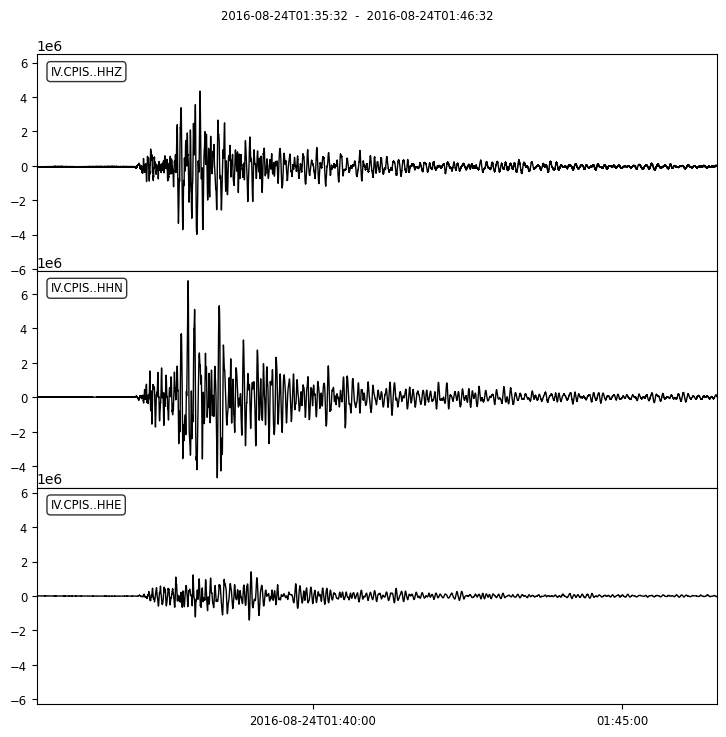

3 Trace(s) in Stream:
IV.CPIS..HHE | 2016-08-24T01:35:32.000000Z - 2016-08-24T01:46:32.000000Z | 100.0 Hz, 66001 samples
IV.CPIS..HHN | 2016-08-24T01:35:32.000000Z - 2016-08-24T01:46:32.000000Z | 100.0 Hz, 66001 samples
IV.CPIS..HHZ | 2016-08-24T01:35:32.000000Z - 2016-08-24T01:46:32.000000Z | 100.0 Hz, 66001 samples


Output()

In [83]:
# -- Get waveform from FDSN service
# [https://docs.obspy.org/packages/obspy.clients.fdsn.html]

# # 2011 Tohoku event
# datacenter = 'BGR'
# t1 = UTCDateTime('2011-03-11T05:00:00.000')
# request = dict(
#     network = "GR",
#     station = "WET",  # ... recorded in Germany
#     location = "",
#     channel = "BHZ",
#     starttime = t1,
#     endtime = t1 + 6 * 60 * 60  # 6 hours
# )

# 2016 Mw6.2 Amatrice
datacenter = 'INGV'
t1 = UTCDateTime('2016-08-24 01:36:32')
request = dict(
    network = "IV",
    station = "CPIS",  # ... recorded at Campi Flegrei; closest (available) station from Napoli
    location = "",
    channel = "HH*",
    starttime = t1 - 60,
    endtime = t1 + 10 * 60  # 10min   
)

client = Client(datacenter)
# client = RoutingClient("eida-routing")

# Memoized get_waveform
def get_waveform_memoized(client, request):
    
    filename = ('data/%s_%s_+%ds' %
            ('_'.join(list(request.values())[:4]), request['starttime'].isoformat()[:19],
             request['endtime'] - request['starttime'])) \
            .replace(':', '-').replace('*', '^').replace('?', '-')

    if not os.path.exists(filename + '.mseed'):
        # st = client.get_waveforms(**request, attach_response=True)
        st = client.get_waveforms(**request)  # get waveforms
        inv = client.get_stations(**request, level='response')  # get inventory / station information
        st.write(filename + '.mseed')
        inv.write(filename + '.xml', format='STATIONXML')
        print('Saved stream locally to %s{.mseed, xml}.' % filename)
    else:
        # Load dumped version
        print('Loaded stream locally from %s{.mseed, xml}.' % filename)
        st = obspy.read(filename + '.mseed')  # save waveforms
        inv = obspy.core.inventory.read_inventory(filename + '.xml')  # save inventory
    
    st.attach_response(inv)
    
    return st 

st_event = get_waveform_memoized(client, request)  # uses locally stored stream, if it exists

st_event.plot()
print(st_event)

def demo_filter_signal2(seistype, tslice, freq_range, max_freq, logfx, logfy, samefy):

    plot_filter_signal(tr_types2, seistype, tslice, freq_range, max_freq, logfx, logfy, samefy)
    

# Precalc parameters
tr = st_event[0].detrend('linear')
trange = [0, tr.stats.delta * tr.stats.npts]
fNy = 1 / (2 * tr.stats.delta)

# Pro tip: we now remove response and convert to DISP, ACC, VEL
# (only works if stations's response info is present in the stream)
tr_types2 = {
    'ACC': tr.copy().remove_response(output="ACC"),  # accelerogram
    'VEL': tr.copy().remove_response(output="VEL"),  # velocity 
    'DISP': tr.copy().remove_response(output="DISP"),  # displacement
}

# Interactive
tslice = ipywidgets.IntRangeSlider(value=trange, min=0, max=trange[1], step=1, description='Time range', continuous_update=False)
seistype = ipywidgets.Dropdown(options=tr_types2.keys(), value='VEL', description='Domain', continuous_update=False)
freq_range = ipywidgets.FloatRangeSlider(value=[0, fNy], min=0, max=fNy, step=0.01, description='Filter range', continuous_update=False)
max_freq = ipywidgets.FloatSlider(value=fNy, min=0, max=fNy, step=0.1, description='Max freq.', continuous_update=False)
def update_freq_range(*args):
    freq_range.max = max_freq.value
max_freq.observe(update_freq_range, 'value')
logfx = ipywidgets.Checkbox(value=False, description='Log freq. scale', continuous_update=False)
logfy = ipywidgets.Checkbox(value=False, description='Log |F(f)| scale', continuous_update=False)
samefy = ipywidgets.Checkbox(value=True, description='Same |F(f)| range', continuous_update=False)


interactive_plot = ipywidgets.interactive_output(
    demo_filter_signal2, {k: globals()[k] for k in {'tslice', 'seistype', 'freq_range', 'max_freq', 'logfx', 'logfy', 'samefy'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([tslice, seistype, ]),
                         ipywidgets.HBox([freq_range, max_freq]),
                         ipywidgets.HBox([logfx, logfy, samefy])]), interactive_plot)

> How does spectrum differ from the previous event?

> Investigate the influence of the ACC/VEL/DISP domain on the spectrum.

> Investigate the influence of changing the filter range on the frequency content.

## Site characterization

The frequency content contains information about the spectral amplification, either:
* compared to rock conditions (need to be modeled)
* between two stations with similar distance and angle to event

The latter is easier. Let's do it.

### Spectral amplification during an event

> Find two stations that are in approx. the same area and have completely different soil conditions.

Saved stream locally to data/IV_BOB__HHZ_2016-08-24T01-35-32_+660s{.mseed, xml}.
Saved stream locally to data/Z3_A312A__HHZ_2016-08-24T01-35-32_+660s{.mseed, xml}.


1 Trace(s) in Stream:
IV.BOB..HHZ | 2016-08-24T01:35:32.000200Z - 2016-08-24T01:46:32.000200Z | 100.0 Hz, 66001 samples


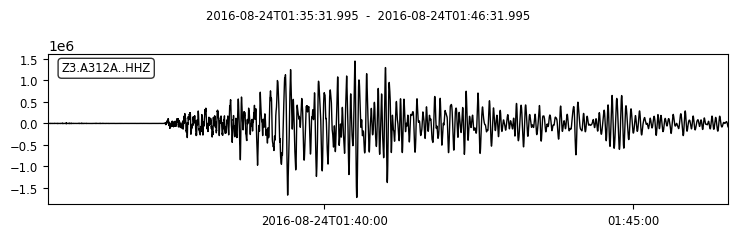

1 Trace(s) in Stream:
Z3.A312A..HHZ | 2016-08-24T01:35:31.995000Z - 2016-08-24T01:46:31.995000Z | 100.0 Hz, 66001 samples


In [84]:
# 2016 Mw6.2 Amatrice
institute = 'INGV'
t1 = UTCDateTime('2016-08-24 01:36:32')

# The one a more rock-like site
request1 = dict(
    network = "IV",
    station = "BOB",  # station on rock-like site
    location = "",
    channel = "HHZ",
    starttime = t1 - 60,
    endtime = t1 + 10 * 60  # 10min   
)
# The one a more soft-soil site
request2 = dict(
    network = "Z3",
    station = "A312A",  # station on soft-soil site
    location = "",
    channel = "HHZ",
    starttime = t1 - 60,
    endtime = t1 + 10 * 60  # 10min   
)

client = Client(institute)
# client = RoutingClient("eida-routing")

st_ev_stn1 = get_waveform_memoized(client, request1)  # uses locally stored stream, if it exists
st_ev_stn2 = get_waveform_memoized(client, request2)  # uses locally stored stream, if it exists

st_ev_stn1.plot()
print(st_ev_stn1)
st_ev_stn2.plot()
print(st_ev_stn2)

---

<a id="instrument-response"></a>

Note that we have to **remove/deconvolve the instrument response** (stored inside the stream) to make seismograms comparable., which considers:
* conversion of measured counts into a physical unit ("sensitivity")
* frequency-dependent behavior

More info:
* [E. Wieland: Seismic Sensors and their Calibration](https://gfzpublic.gfz-potsdam.de/rest/items/item_4019/component/file_4020/content)
* [docs.obspy.org/.../seismometer_correction_simulation](https://docs.obspy.org/tutorial/code_snippets/seismometer_correction_simulation.html)

---

In [85]:
def plot_spec_comparison(tslice1, tslice2, logfx, max_freq, logfy):
    
    trs = [tr1, tr2]
    tslices = [tslice1, tslice2]

    trs_ = []
    ts = []
    fs = []
    Fspecs = []
    
    # Perform for both waveforms:
    for i, tr in enumerate(trs):
    
        tr_ = tr.slice(tr.stats.starttime + tslices[i][0],
                       tr.stats.starttime + tslices[i][1])
        trs_.append(tr_)
        
        ts.append(tr_.times() + tslices[i][0])
    
        nsamp = tr_.stats.npts                 # number of samples in the trace
        dt = tr.stats.delta                    # sample interval
        fNy = 1 / (2 * dt)                     # Nyquist frequency
        fs.append(np.linspace(0, fNy, nsamp // 2 + 1))  # frequency axes for plotting
        
        taper = cosine_taper(nsamp, 0.2)  # don't forget to taper!

        # Perform FFT
        Fspecs.append(abs(np.fft.rfft(tr_.data * taper)))
    
    if Fspecs[0].size > Fspecs[1].size:
        fs_common = fs[1]
        FspecR = Fspecs[1] / np.interp(fs[1], fs[0], Fspecs[0])
    elif Fspecs[0].size < Fspecs[1].size:
        fs_common = fs[0]
        FspecR = np.interp(fs[0], fs[1], Fspecs[1]) / Fspecs[0]
    else:
        fs_common = fs[0]
        FspecR = Fspecs[1] / Fspecs[0]

    max_Fspec = max(Fspecs[0].max(), Fspecs[1].max())
    fNy_min = min(1 / (2 * tr1.stats.delta), 1 / (2 * tr2.stats.delta))
    max_freq = max_freq or fNy_min
    
    # ---------------------------------------------------------------
    # Plot
    fig = plt.figure(figsize=(10, 8))

    fig.add_subplot(3,2,1)
    plt.plot(ts[0], trs_[0].data, '0.3', lw=0.7)
    plt.title('Time-domain')
    plt.ylabel('Amplitude @ %s' % trs[0].stats.station)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    fig.add_subplot(3,2,2)
    plt.plot(fs[0], Fspecs[0], '0.3', lw=0.7)
    plt.title('Frequency-domain\n(amplitude spectrum)')
    plt.ylabel('$|F_1(f)|$')
    plt.gca().set_xscale('log' if logfx else 'linear')
    plt.gca().set_yscale('log' if logfy else 'linear')
    plt.xlim(0.01 if logfx else 0, max_freq)
    plt.ylim(top=max_Fspec * (2 if logfy else 1.1))
    if not logfy:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    fig.add_subplot(3,2,3)
    plt.plot(ts[1], trs_[1].data, '0.3', lw=0.7)
    plt.xlabel('Time')
    plt.ylabel('Amplitude @ %s' % trs[1].stats.station)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    fig.add_subplot(3,2,4)
    plt.plot(fs[1], Fspecs[1], '0.3', lw=0.7)
    plt.ylabel('$|F_2(f)|$')
    plt.gca().set_xscale('log' if logfx else 'linear')
    plt.gca().set_yscale('log' if logfy else 'linear')
    plt.xlim(0.01 if logfx else 0, max_freq)
    plt.ylim(top=max_Fspec * (2 if logfy else 1.1))
    if not logfy:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    fig.add_subplot(3,2,6)
    idx_fmax = np.argmin(np.abs(fs_common - max_freq)) + 1
    plt.plot(fs_common, FspecR, '0.3', lw=0.7)
    plt.xlabel('Frequency')
    plt.ylabel('$|F_2(f)|/|F_1(f)|$')
    plt.axhline(1, c='0.5', lw=0.5)
    plt.gca().set_xscale('log' if logfx else 'linear')
    plt.gca().set_yscale('log' if logfy else 'linear')
    plt.xlim(0.01 if logfx else 0, max_freq)
    plt.ylim(0.01 if logfy else 0, FspecR[:idx_fmax].max()*1.1)
    if not logfy:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

    # plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()


tr1 = st_ev_stn1[0].copy().detrend('linear')
tr1.remove_response(output="VEL")

tr2 = st_ev_stn2[0].copy().detrend('linear')
tr2.remove_response(output="VEL");

trange1 = [0, tr2.stats.delta * tr1.stats.npts]
trange2 = [0, tr2.stats.delta * tr2.stats.npts]

# Interactive
tslice1 = ipywidgets.IntRangeSlider(value=trange1, min=0, max=trange1[1], step=1, description='Time range S1', continuous_update=False)
tslice2 = ipywidgets.IntRangeSlider(value=trange2, min=0, max=trange2[1], step=1, description='Time range S2', continuous_update=False)
logfx = ipywidgets.Checkbox(value=False, description='Log freq. scale', continuous_update=False)
max_freq = ipywidgets.FloatSlider(value=fNy, min=0.1, max=fNy, step=0.1, description='Max freq.', continuous_update=False)
logfy = ipywidgets.Checkbox(value=False, description='Log |F(f)| scale', continuous_update=False)

interactive_plot = ipywidgets.interactive_output(
    plot_spec_comparison, {k: globals()[k] for k in {'tslice1', 'tslice2', 'logfx', 'max_freq', 'logfy'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([tslice1, logfx, max_freq]),
                         ipywidgets.HBox([tslice2, logfy])]), interactive_plot)

Output()

(Note: the amplitude range of the two event spectra have the same range)

> Did the amplitude spectra and their ratio meet your expectations? What do you observe?

### H/V ratio

= the ratio between the Fourier amplitude spectra of horizontal (H) to vertical (V) components of the *ambient noise* vibrations recorded at one single station.

Why is it useful?
* related to the composition of the seismic wave field responsible for the ambient vibrations
* the wave field in turn **depends** both **on** the sources of theses vibrations (not important for our interest), and on the **underground structure** (we are interested!).
* a high ratio at a certain frequency means: no contribution at this frequency from vertical component
    * actual reason: when the S-wave resonates, it suppresses the Rayleigh wave (vertically)
    * --> **identify**:
        * the **site response/amplification**
        * the **fundamental frequency**, $f_0$ of soft soils (the lower, the thicker the sediment, i.e., the the deeper the rock layer)

Why is the H/V ratio famous?
* it's reliable, very easy, and quick to do

More details:
* [geopsy.org/documentation/geopsy/hv.html](https://www.geopsy.org/documentation/geopsy/hv.html)
* [Atakan et al. 2004](https://www.iitk.ac.in/nicee/wcee/article/13_2268.pdf)
* [`hvsrp`](https://github.com/jpvantassel/hvsrpy) - dedicated H/V-ratio Python package (not used here)

For it to work, we **need longer (and noisy) seismograms**.


#### Using longer seismograms

Find suitable stations:
* [INGV Rete Sismica IV](http://terremoti.ingv.it/instruments/network/IV)
* [EIDA Italia](https://eida.rm.ingv.it/it/)
* [ORFEUS Stationbook](https://orfeus-eu.org/stationbook/) (for Europe)
* by Datacenter/Network: [IRIS MetadataAggregator](https://ds.iris.edu/mda/) (for whole World)

Note: use only velocimeters (`?H?`); accelerometers (`?N?`) are not appropriate due to their insensitivity to noise measurements.

For a well-working H/V, **the noisier** the signal (less impulsive events), **the better**.



In [86]:
datacenter = 'INGV'
duration = 1 * 60 * 60  # [h]
t2 = UTCDateTime().now() - duration
t2 = UTCDateTime('2022-10-17 00:00:00')  # in UTC, i.e., -1 or -2h from our local time
request = dict(
    network = "IV",
    station = "CMSN",  # CMSN | CSFT, CSOB, CSTH | ICVJ  | LATB | RDP, SAMA (weird data) |  only ?N?: ROM9
    location = "",
    channel = "?H?",  # note: accelerometers (?N?) are not useful for us
    starttime = t2,
    endtime = t2 + duration
)

client = Client(datacenter)
# client = RoutingClient("eida-routing")

st_long_raw = get_waveform_memoized(client, request)  # uses locally stored stream, if it exists

st_long_raw.plot()
print(st_long_raw)

Saved stream locally to data/IV_CMSN__-H-_2022-10-17T00-00-00_+3600s{.mseed, xml}.


3 Trace(s) in Stream:
IV.CMSN..HHE | 2022-10-17T00:00:00.000000Z - 2022-10-17T01:00:00.000000Z | 100.0 Hz, 360001 samples
IV.CMSN..HHN | 2022-10-17T00:00:00.000000Z - 2022-10-17T01:00:00.000000Z | 100.0 Hz, 360001 samples
IV.CMSN..HHZ | 2022-10-17T00:00:00.000000Z - 2022-10-17T01:00:00.000000Z | 100.0 Hz, 360001 samples


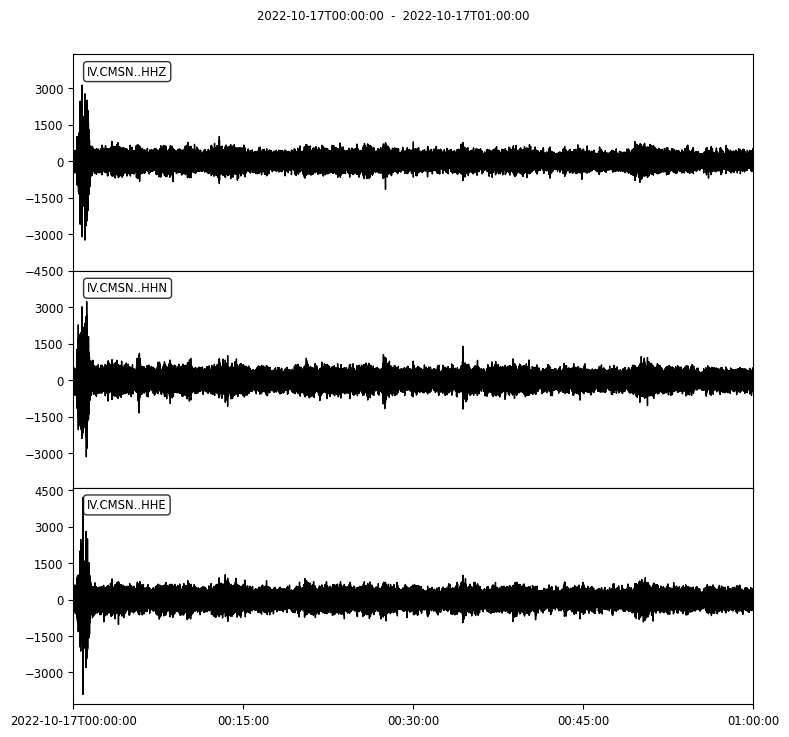

In [87]:
st_long = st_long_raw.copy()  # always take a copy - so that we don't have to load the stream again

# Detrend (only one!)
st_long.detrend('linear')
# st_long.detrend('polynomial', order=2)
# st_long.detrend('spline', order=4, dspline=1000)

# Remove very low freq
st_long.filter('highpass', freq=0.02)

st_long.plot();

#### Spectrum of long seismograms

Let's try different methods to estimate spectrum:
* FFT
* Short-time FFT (STFT) - recall the short-term FT / spectrogram of Exercise 1


In [88]:
def calc_spec_FFT(tr, scale='spectrum'):
    """Compute Periodogram via FFT"""
    
    nsamp = tr.stats.npts  # number of samples in the trace
    fNy = 1 / (2 * tr.stats.delta)   # Nyquist frequency
    f = np.linspace(0, fNy, nsamp // 2 + 1)
    
    taper = cosine_taper(nsamp, 0.2)  # don't forget to taper!
    X = np.fft.rfft(tr.data * taper)
    Fx = abs(X)
    if scale.lower() == 'psd':
        norm = nsamp * tr.stats.sampling_rate
        Fx = Fx**2 / norm

    return f, Fx


def calc_spec_periodogram(tr, scale='spectrum'):
    """Compute Periodogram via scipy (equivalent to FFT, but 1x faster)"""
    
    taper = cosine_taper(tr.stats.npts, 0.2)  # don't forget to taper!
    f, Fx = scipy.signal.periodogram(
        tr.data, fs=tr.stats.sampling_rate,
        window=taper,
        scaling=scale.lower().replace('psd', 'density')
    )
    if scale.lower() == 'spectrum':
        norm = tr.stats.npts # * tr.stats.sampling_rate
        Fx = np.sqrt(Fx) * norm
    
    return f, Fx


def calc_spec_STFFT(tr, NFFT, scale='spectrum', perc_overlap=0.5):
    """Compute Short-time FFT"""
    
    # NFFT = 1024  # length of segment
    # perc_overlap = 0.5
    window = 'hann'
    n_overlap = int(NFFT * perc_overlap)
    
    # f, t, Fx = scipy.signal.stft(  # returns complex FFT
    #     tr.data, fs=tr.stats.sampling_rate,
    #     window=window, nperseg=NFFT, noverlap=n_overlap,
    #     scaling=scale.lower().replace('density', 'psd')
    # )
    # Fx = np.abs(Fx)
    # if scale.lower() == 'psd':
    #     Fx = Fx**2
    
    # Equivalent for spectrum, but not density:
    # For psd, equivalent to Welch (averages in density domain)
    f, t, Fx = scipy.signal.spectrogram(
        tr.data, fs=tr.stats.sampling_rate,
        window=window, nperseg=NFFT, noverlap=n_overlap,
        mode=scale.lower().replace('spectrum', 'magnitude'),
        scaling=scale.lower().replace('psd', 'density')
    )
    
    if scale.lower() == 'spectrum':
        Fx *= t.size * (NFFT + n_overlap) * tr.stats.delta   # TODO: find out normalization
    
    return f, Fx


def calc_spec_Welch(tr, NFFT, scale='spectrum'):
    """Estimate Spectra by Welch's method"""
    """Attention: averages in psd domain"""
    
    # NFFT = 1024  # length of segment
    perc_overlap = 0.5
    window = 'hann'
    n_overlap = int(NFFT * perc_overlap)
    
    f, Fx = scipy.signal.welch(
        tr.data, fs=tr.stats.sampling_rate,
        window=window, nperseg=NFFT, noverlap=n_overlap,
        scaling=scale.lower().replace('psd', 'density')
    )
    if scale.lower() == 'spectrum':
        norm = nsamp * tr.stats.sampling_rate
        Fx = np.sqrt(Fx * norm)

    return f, Fx


def plot_spectra(viaFFT, viaPeriodogram, viaSTFT, viaWelch, NFFT, logfx, logfy, scale='spectrum'):
    
    dt = tr.stats.delta  # sampling inverval
    # dt = 1 / tr.stats.sampling_rate  # sampling inverval
    fNy = 1 / (2 * dt)   # Nyquist frequency

    # Plot results
    fig = plt.figure(figsize=(10, 4))
    if viaFFT:
        plt.plot(*calc_spec_FFT(tr, scale), '0.3', lw=0.5,
                 label='%s (FFT)' % scale)
    if viaPeriodogram:
        plt.plot(*calc_spec_periodogram(tr, scale), 'C0', lw=0.7,
                 label='%s (Periodogram)' % scale)
    if viaSTFT:
        f, Fxx = calc_spec_STFFT(tr, NFFT, scale)
        Fxx = Fxx.mean(1)  # average along time axis
        plt.plot(f, Fxx, 'C1',
                 label='%s (STFT)' % scale)
    if viaWelch:
        plt.plot(*calc_spec_Welch(tr, NFFT, scale), 'crimson',
                 label='%s (Welch)' % scale)
    plt.xlabel('Frequency')
    plt.ylabel('|F(f)|%s' % ('²' if scale.lower() == 'psd' else ''))
    plt.xlim(0.001 if logfx else -0.5, fNy)
    # plt.ylim(bottom=10**-8)
    plt.xscale('log' if logfx else 'linear')
    plt.yscale('log' if logfy else 'linear')
    plt.legend()

    plt.show()
    fig.clear()
    plt.close(fig)


tr = st_long \
    .select(component="Z")[0] \
    .copy().remove_response(output="VEL")

# Interactive
viaFFT = ipywidgets.Checkbox(value=True, description='via rFFT', continuous_update=False)
viaPeriodogram = ipywidgets.Checkbox(value=False, disabled=True, description='via Periodogram', continuous_update=False)
viaSTFT = ipywidgets.Checkbox(value=True, description='via STFT', continuous_update=False)
viaWelch = ipywidgets.Checkbox(value=False, disabled=True, description='via Welch', continuous_update=False)
NFFT = ipywidgets.Dropdown(options=[2**x for x in range(8, 16)], description='NFFT', continuous_update=False)
logfx = ipywidgets.Checkbox(value=False, description='Log freq. scale', continuous_update=False)
logfy = ipywidgets.Checkbox(value=True, description='Log |F(f)| scale', continuous_update=False)
scale = ipywidgets.Dropdown(options=['Spectrum', 'PSD'], description='Scaling', continuous_update=False)
def update_checkboxes(*args):
    if scale.value == 'PSD':
        viaPeriodogram.disabled = False
        viaWelch.disabled = False
    else:
        viaPeriodogram.disabled = True
        viaWelch.disabled = True
scale.observe(update_checkboxes, 'value')

interactive_plot = ipywidgets.interactive_output(
    plot_spectra, {k: globals()[k] for k in {'viaFFT', 'viaPeriodogram',
                                             'viaSTFT', 'viaWelch', 'NFFT', 'logfx', 'logfy', 'scale'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([viaFFT, viaPeriodogram, scale, logfx]),
                         ipywidgets.HBox([viaSTFT, viaWelch, NFFT, logfy])]), interactive_plot)

Output()

<!-- > Why do we need to norm |F(f)|² by $N * 1/\Delta = N \Delta f$? -->

> Which one do you like more and why?
<!--  periodogram's deficiency: noisy; b/c the variance at a given frequency does not decrease as N increases -->

> Can you imagine what STFT approach make different. Why are they smoother?
<!-- = averaged periodograms: divide in multiple shorter, overlapping segments, FFT each, average -->

> Investigate the influence of NFFT (tip: also in *Log freq. scale*)

---

**Bonus**

In addition, we can switch to the *Power Spectral Density* (PSD), also called *power spectrum*: $|F(f)|^2$ normalized by $N/\Delta t = N \Delta f$
* = distribution of **power** in the frequency components 
* = spectral energy distribution **per unit time** --> integrating $|F(f)|^2$ gives the signal energy

> What happens to the signal without and with *Log |F(f)| scale*?

The PSD can be obtained also in another way:
* Using either:
    * [Periodogram](https://en.wikipedia.org/wiki/Periodogram)
    * [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)

> Do you notice similarities to FFT and STFT?
<!-- Yes, they are their analogs, respectively. -->

#### Obtain H/V ratio

We use the STFT to compute the H/V ratio.

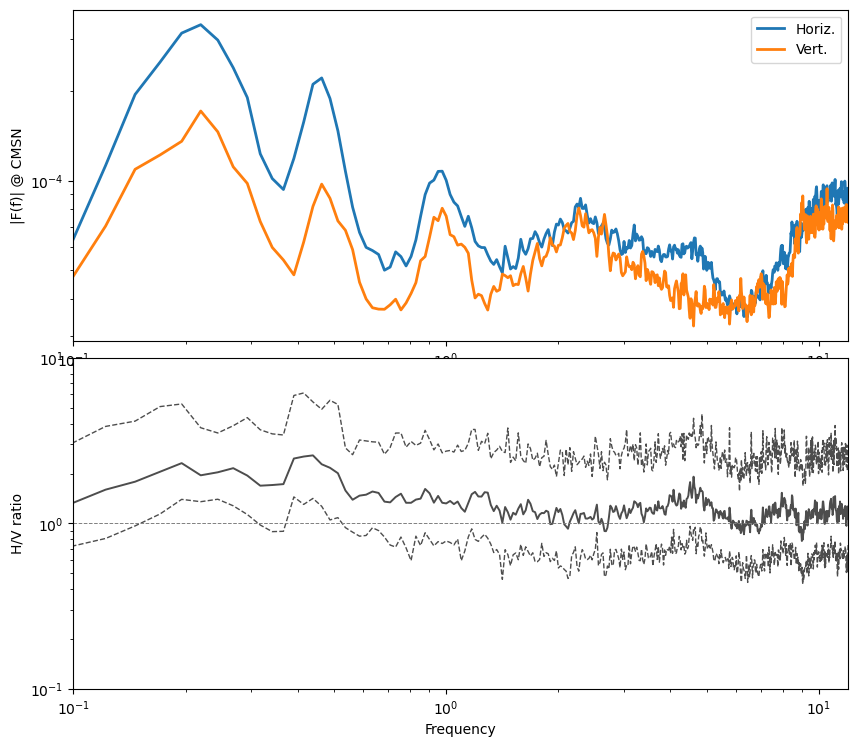

In [89]:
def plot_HVsr(st, NFFT, maxf=12, show_all_segments=True, logfx=True, logfy=True):
# st = st_long.copy().remove_response(output="VEL")
# NFFT = 4096
# maxf=10
# logfy=True

    # Vertical component
    f, Fxs_V = calc_spec_STFFT(st.select(component='Z')[0], NFFT, perc_overlap=0.0)

    # Horizontal component
    # Var 1. Combine traces in time domain (not sure if correct)
    # tr_H = st[1].copy()  # create a dummy trace for storing ...
    # tr_H.data = np.linalg.norm(np.vstack((st.select(component='N')[0].data,  # combination of both with
    #                                       st.select(component='E')[0].data)), ord=2, axis=0)  # L2 norm
    # _, Fxs_H = calc_spec_STFFT(tr_H, NFFT, perc_overlap=0.0)
    # Var 2. Combine traces in frequency domain
    _, Fxs_H1 = calc_spec_STFFT(st.select(component='N')[0], NFFT, perc_overlap=0.0)
    _, Fxs_H2 = calc_spec_STFFT(st.select(component='E')[0], NFFT, perc_overlap=0.0)
    Fxs_H = np.sqrt((Fxs_H1**2 + Fxs_H2**2) / 2)  # squared average
    # Fxs_H = np.sqrt(Fxs_H1 * Fxs_H2)  # geometric mean

    dt = st[0].stats.delta  # sampling inverval
    # dt = 1 / tr.stats.sampling_rate  # sampling inverval
    fNy = 1 / (2 * dt)   # Nyquist frequency

    maxf_idx = abs(f - maxf).argmin()
    f = f[:maxf_idx]
    Fxs_H = Fxs_H[:maxf_idx]
    Fxs_V = Fxs_V[:maxf_idx]
    Fx_H = Fxs_H.mean(1)  # average along time axis
    Fx_V = Fxs_V.mean(1)

    # Calculate ratio
    HVxRs = Fxs_H / Fxs_V
    HVxR = Fx_H / Fx_V  # mean
    HVxRs_stds = HVxRs.std(1)

    # Plot
    fig, ax = plt.subplots(nrows=2, figsize=(10, 9), gridspec_kw=dict(height_ratios=(1, 1), hspace=0.05))

    # Spectra
    plt.sca(ax[0])
    if show_all_segments:
        for i, _ in enumerate(Fxs_H.T):
            plt.plot(f, Fxs_H.T[i], 'C0', marker='.', ms=3, ls='none', alpha=0.05)
            plt.plot(f, Fxs_V.T[i], 'C1', marker='.', ms=3, ls='none', alpha=0.05)
    plt.plot(f, Fx_H, 'C0', lw=2.0, label='Horiz.')
    plt.plot(f, Fx_V, 'C1', lw=2.0, label='Vert.')

    plt.ylabel('|F(f)| @ %s' % tr.stats.station)
    plt.xlim(0.1, maxf)
    plt.xscale('log' if logfx else 'linear')
    # plt.ylim(0.1, 10)
    plt.yscale('log' if logfy else 'linear')
    plt.legend(loc=1)

    # H/V ratio
    plt.sca(ax[1])
    if show_all_segments:
        for hvxr in HVxRs.T:
            plt.plot(f, hvxr, '0.5', marker='.', ms=3, ls='none', alpha=0.1)
    plt.plot(f, HVxR, '0.3', lw=1.4, label='H/V')
    # plt.plot(f, scipy.signal.savgol_filter(HVxR, 11, 3), '0.3', lw=2, label='H/V')
    plt.plot(f, np.percentile(HVxRs, 84.1, 1), '0.3', lw=1.0, ls='--', label='84%-ile')
    plt.plot(f, np.percentile(HVxRs, 15.9, 1), '0.3', lw=1.0, ls='--', label='16%-ile')

    # TODO: 2D histogram
    # np.logspace(-1, 1)
    # np.logspace(-2, 2, 300)
    # plt.hist2d(np.tile(f, HVxRs.shape[1]), HVxRs.ravel(), bins=(50, 50), cmap=plt.cm.jet)

    plt.axhline(1, c='0.5', ls='--', lw=0.7)
    plt.xlabel('Frequency')
    plt.ylabel('H/V ratio')
    plt.xlim(0.1, maxf)
    plt.xscale('log' if logfx else 'linear')
    plt.ylim(0.1, 10)
    plt.yscale('log' if logfy else 'linear')
    # plt.legend(loc=1)

    plt.show()
    fig.clear()
    plt.close(fig)

plot_HVsr(st_long.copy().remove_response(output="VEL"), 4096, maxf=12, show_all_segments=False,
          logfx=True, logfy=True)

> Can you find a station that has a high H/V ratio in this frequency range? (remember which subsoil amplifies waves)

**Bonus**: since we use the STFT, the H/V ratio can be computed for every segment. You can visualize them by setting `show_all_segments=True`.

## Estimating seismic moment, magnitude, and other source parameters

Back to seismograms of individual events...

According to the *Brune spectral model* [[Brune 1970](https://doi.org/10.1029/JB075i026p04997), 1971], an earthquake causes a (far-field) displacement pulse $u(r,t)$ at some station with its corresponding **far-field displacement spectrum** $\Omega(f)$, which can be observed and modeled as:
$$S(f) = \frac{\Omega_0}{1+(f/f_c)^2} \cdot e^{-\pi f t^*}$$

in which:
* $\Omega_0$: the long-period amplitude $\Omega(0)$
* $f_c$: the corner frequency of $\Omega(f)$
* $e^{-\pi f t^*}$: the frequency-dependent attenuation of seismic waves
    * $t^* = \frac{t_\text{travel}}{Q}$, with $t_\text{travel}$ the travel time of the seismic wave to the station and $Q$ the frequency-independent quality factor

To obtain those, we fit the Brune model $S(f)$ to $\Omega(f)$; i.e., invert for $\Omega_0, f_c, t^*$. The $S(f)$ that describes $\Omega(f)$ best gives us the optimal estimates for these three parameter values. In this way, we obtain information about the source event:

1. $u(r,t)$, and therefore $\Omega_0$, are proportional to the seismic moment, $M_0$, of the recorded event, i.e.,
$$M_0 = C \cdot \Omega_0$$
$C$ captures the propagation effect (radiation and attenuation) of seismic waves from the source to the station: geometrical spreading due to distance $r$ between them, radiation pattern $R_c$, seismic wave speed $v$, and density of the medium $\rho$, i.e.,
$$M_0 = 4\pi\rho v^3 r \frac{\Omega_0}{R_c}$$
$M_0$ can be related to the moment magnitude [Kanamori 1979]:
$$M_w = \frac{2}{3} \log_{10} M_0 - 9.1$$
*Be aware that the observed $\Omega(f)$ also depends on the instrument response. We need to know and correct for it (<a href="#instrument-response">see above</a>); otherwise $\Omega_0$ is physically not meaningful.*

2. $f_c$ reflects the source frequency content (e.g., by how much the radiated/recorded waveforms are enriched with high frequencies). From $f_c$, we can infer the source radius $r_\text{source} = \frac{k v}{f_c}$; $k$ is some factor [[Madariaga 1976](https://pubs.geoscienceworld.org/ssa/bssa/article/66/3/639/117579/Dynamics-of-an-expanding-circular-fault)]

(Besides, $t^*$ gives us an estimate of the attenuation factor, represented by $Q = \frac{t_\text{travel}}{t^*}$.)

$M_0$ and $f_c$ together lets us estimate of the (dynamic) stress drop $\Delta\sigma$ [[Eshelby 1957](https://royalsocietypublishing.org/doi/10.1098/rspa.1957.0133)]:
$$\Delta\sigma = \frac{7}{16} \left(\frac{f_c}{kv}\right)^3 M_0 = \frac{7}{16} \frac{M_0}{r_\text{source}^3}.$$
Typically, $f_0$ decreases with increasing $M_0$ so that the stress drop is rather independent from the size of the earthquake.
However, for similar-sized earthquakes, the stress drop was observed to vary over 3-4 orders of magnitude; but more on that another time...

---

Let's reuse the event waveform (see [Get your own seismogram](#Get-your-own-seismograms-(for-a-specific-event))) that you loaded above. Correcting for the instrument response yields:

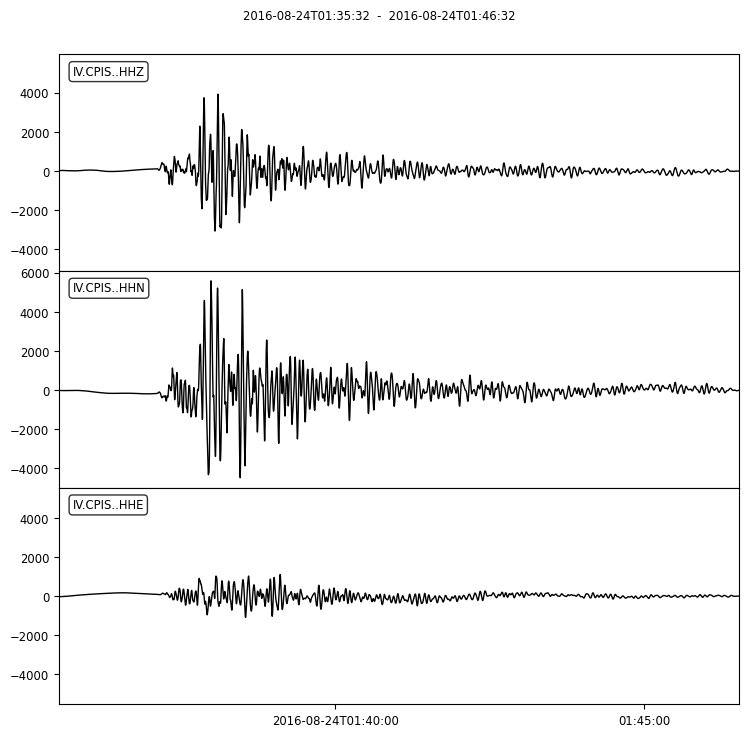

In [90]:
# Properly remove/correct/deconvolve instrument response
# [https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html
# [https://docs.obspy.org/tutorial/code_snippets/seismometer_correction_simulation.html]
st_eventDISP = st_event.copy().remove_response(
    output="DISP",
    # water_level=60, 
    # water_level=None, pre_filt=[0.001, 0.005, 10, st_event[0].stats.sampling_rate // 2], 
    # plot=True
)

st_eventDISP.plot();

Besides the origin time, we have to also provide the onset of the P- & S-phase, i.e., their 'picks'. Take those three times from the event page at IRIS and add change the dictionary variable `times` below accordingly.

In [91]:
# -- Spectral inversion for seismic moment and corner frequency
# Based on : https://github.com/krischer/moment_magnitude_calculator
# but modified by MH

# PYSICAL parameters
DENSITY = 2650.0  # Rock density in km/m^3
VELOCITY = {  # [m/s]
    'P': 5940,  # P-wave 
    'S': 3450  # S-wave
    # 'S': V_P / 1.73
}
RADIATION_PATTERN = {
    'P': 0.52,
    'S': 0.63}
kFACT = {
    'P': 0.32,
    'S': 0.21}
     
# FITTING setup
INITIAL_F_C = 1  # initial guess for the corner frequency
INITIAL_QUALITY_FACT = 100  # initial guess for the quaility factor
HF_FALLOFF = 2  # high frequency fall-off rate on a log-log plot (exponent n in Abercrombie 1995)

# Optimization method
OPTIMIZATION_METHOD = 'lm'   # Levenburg-Marquardt algorithm
# OPTIMIZATION_METHOD = 'trf'  # 'trf': Trust Region Reflective algorithm
#                              ... is faster and doesn't yield RuntimeWarnings due to negative
#                              values in fitting  (b/c it allows constraints)


def calculate_source_spectrum(freq, omega_0, f_c, t_star):
    """
    After Brune (1970):
        Omega(f) = Omega(0) / (1 + (f/f_c)^2) * e^(-pi * f * t*)
        
            e^(-pi * f * t*) is the attenuation model; t* = t_traveltime / Q
    
    freq: frequency vector
    omega_0: low-frequency amplitude in [meter x second].
    f_c: corner frequency in [Hz].
    t_star: factor capturing the attenuation (includes traveltime and quality factor)
    """
    
    gamma = 1  # Brune
    # gamma = 2  # [Boatwright 1980] (sharper corner than Brune)

    # num = omega_0  # without attenuation
    num = omega_0 * np.exp(-np.pi * freq * t_star)  # with attenuation (from Boatwright)
    denom = (1 + (freq / f_c) ** (gamma * HF_FALLOFF)) ** (1 / gamma)
    
    return num / denom


def fit_spectrum(spec, freq, initial_omega_0, initial_f_c, initial_Q, traveltime):
    """
    Fit a theoretical source spectrum to a measured source spectrum.

    :pec: measured source spectrum
    freq: corresponding freq
    initial_omega_0: initial guess for Omega_0 (low frequency amplitude).
    initial_f_c: initial guess for the corner frequency.

    Returns: Best fits and standard deviations.
        (Omega_0, f_c, Omega_0_std, f_c_std)
        Returns None, if the fit failed.
    """

#    def f(freq, omega_0, f_c):
#        return calculate_source_spectrum(freq, omega_0, f_c)
#    
#    try:
#        popt, pcov = scipy.optimize.curve_fit(
#            f, freq, spec, p0=list([initial_omega_0, initial_f_c]), maxfev=100000)
#    except Exception as err:
#        raise err
#    return popt[0], popt[1], pcov[0, 0], pcov[1, 1]

    # -- [mh mod]

    # Scale spectra to avoid extremely small values in numerical optimization algorithm
    #    --> circumvent numerical limits, make robust
    # After fitting, account for rescaling
    x_scale = 1. / spec.mean()
    spec = spec * x_scale  # copy
    initial_omega_0 = initial_omega_0 * x_scale  # copy
    
    initial_t_star = traveltime / initial_Q
    
    p0 = (initial_omega_0, initial_f_c, initial_t_star)

    bounds = ((-1, 0, 0), (x_scale, np.inf, np.inf))  # Only used for 'TRF' algorithm

    if OPTIMIZATION_METHOD == 'trf':
        # Trust Region Reflective algorithm
        kwargs = {'bounds': bounds,
                  'method': 'trf',
#                  'x_scale': (np.finfo(np.float).eps, 1, 1),  # Give scale {not needed}
#                  'gtol': np.finfo(np.float).eps,  # modify b/c spectra is tiny {not needed}
#                  'verbose': 1,  # To see when/why iterations terminated
                  'max_nfev': 1000}
    else:
        # Levenburg-Marquardt algorithm
        kwargs = {'method': 'lm',
                  'maxfev': 100000}

    try:
        popt, pcov = scipy.optimize.curve_fit(
            calculate_source_spectrum, freq, spec, p0=p0, **kwargs)
    except Exception as err:
        print("curve_fit didn't return results;", err)  # DEBUG
        raise err

    # Account for scaling factor
    popt[0] /= x_scale
    pcov[0, 0] /= x_scale
    
    popt[2] = traveltime / popt[2]  # convert t_star to Q

    # abs() fixes occasional negative fc
    return popt[0], abs(popt[1]), popt[2], pcov[0, 0], pcov[1, 1], pcov[2, 2]


def perform_spectral_fit(phase, tdur, NFFT=1024):
    
    st_ = st.slice(times[phase], times[phase] + tdur)
    
    if phase == 'P' and times[phase] + tdur > times['S']:
        print("WARNING: You included part of the S-phase; reduce the window length (< %ds)." %
               (times['S'] - times['P']))
    
    fig, ax = plt.subplots(nrows=2, figsize=(6, 6), gridspec_kw=dict(height_ratios=(2, 3), hspace=0.35))
    
    # Plot Seismogram
    plt.sca(ax[0])
    for i, tr in enumerate(st_):
        plt.plot(tr.times(), tr.data, ['0.3', 'C0', 'C1'][i], lw=0.7, label=tr.stats.channel)
    plt.ylabel('Displacement [m] @ %s' % tr.stats.station)
    plt.xlabel('Time after %s-phase onset' % phase)
    plt.legend(loc=(1.02, 0))
    
    # Travel time = phase onset - origin time
    traveltime = times[phase] - times['origin']
    distance = traveltime * VELOCITY[phase]  # distance from event to station
    
    # Calculate spectra
    specs = []

    for tr in st_:
        f, Fxx = calc_spec_STFFT(tr, NFFT)
        specs.append(Fxx.mean(1))
        # # spec, f = mtspec.mtspec(data_window, trace.stats.delta, 2)
        # spec, f, jackknife_errors, _, _ = mtspec.mtspec(
        #     data_window, trace.stats.delta, 3, statistics=True)
    spec3 = np.linalg.norm(specs, ord=2, axis=0)
    
    # Fit Brune model to seismic source displacement spectrum [Brune, 1970]:
    Omega_0, f_c, Q, Oerr, fcerr, Qerr = fit_spectrum(spec3, f, spec3.max(), INITIAL_F_C,
                                                      INITIAL_QUALITY_FACT, traveltime)
    # Omega_0 = np.sqrt(Omega_0)
    
    # Calculate seimic moment M_0 from 
    # of a 
    M_0 = (4.0 * np.pi * DENSITY * VELOCITY[phase] ** 3 * distance * Omega_0 /
           RADIATION_PATTERN[phase])
    Mw = 2.0 / 3.0 * (np.log10(M_0) - 9.1)  # Moment Magnitude [Kanamori 1979]
    
    # Calculate the source radius from the spectral corner frequency
    # assuming a circular rupture. After (Madariaga, 1976)
    r = kFACT[phase] * VELOCITY[phase] / f_c

    # [PLOT] Spectra & fit
    plt.sca(ax[1])
    plt.plot(f, spec3, color='0.1', label='Quadratic mean')
    for i, spec in enumerate(specs):
        plt.plot(f, spec, color=['0.3', 'C0', 'C1'][i], lw=1.0, label=st_[i].stats.channel)
    # plt.fill_between(f, jackknife_errors[:, 0], jackknife_errors[:, 1],
    #                 facecolor="0.75", alpha=0.5, edgecolor="0.5")

    f_fit = np.logspace(-3, np.log10(f[-1]), 100)
    spec_fit = calculate_source_spectrum(f_fit, Omega_0, f_c, traveltime / Q)
    plt.plot(f_fit, spec_fit, color='crimson', lw=2, label='Fit spectrum')
    plt.axvline(f_c, c='C0', ls=':', lw=1)
    plt.xlabel('Frequency')
    plt.ylabel('|F(f)|')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc=(1.02, 0))
    
    plt.show()
    
    stress_drop = 7 / 16 * M_0 / r**3 /1e6  # [MPa = MN/m²] [Eshelby 1957] 

    print("Estimated parameter values:")
    print('%s ::  M0=%.2e Nm >> Mw=%.2f  |  f_c=%.2f Hz  |  Q=%.1f  |  src_rad=%.1f m  |  Δ𝜎=%.2f MPa' %
          (phase, M_0, Mw, f_c, Q, r, stress_drop))

st = st_eventDISP

# Provide the P- & S-phase pick here (as read on IRIS)
times = {
    'origin': UTCDateTime('2016-08-24 01:36:32'),
    'P': UTCDateTime('2016-08-24 01:37:06'),
    'S': UTCDateTime('2016-08-24 01:37:33')
}
# phase = 'S'
# tdur = 15

# perform_spectral_fit(phase, tdur, NFFT=512)

# Interactive
phase = ipywidgets.RadioButtons(options=['P', 'S'], description='Phase', continuous_update=False)
tdur = ipywidgets.IntSlider(value=25, min=5, max=60, step=1, description='Length', continuous_update=False)
NFFT = ipywidgets.Dropdown(options=[2**x for x in range(8, 12)], value=1024, description='NFFT', continuous_update=False)

interactive_plot = ipywidgets.interactive_output(
    perform_spectral_fit, {k: globals()[k] for k in {'phase', 'tdur', 'NFFT'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([phase, tdur, NFFT])]), interactive_plot)

Output()

Oops, in this case, the magnitude is totally wrong (`Mw10.80` for `CMSN`). That's because the seismogram (displacement in meter) contains completely unreasonable values, even with the instrument response removed. Apparently, the provided instrument response of the station is incorrect.

> Try another station until you find one with a reasonable correction of the instrument response: go back to [Get your own seismogram](#Get-your-own-seismograms-(for-a-specific-event)), remove instrument response (the max. displacement should be < 0.01m) and repeat.
> <details>
    <summary>Tip (<b>click to reveal</b>)</summary>
    <i>
    For instance, try <tt style="background:#EEEEEE">IOCA</tt> on Ischia.
    </i>
</details>

Be aware that the estimated $M_o$ and $M_w$ depend strongly on the many assumptions regarding the propagation effect (see above). For illustration purposes, we just used some generic parameters; they may be different for each station. The official estimate for the Amatrice event is $M_w$6.0 by INGV: [http://cnt.rm.ingv.it/event/7073641](http://cnt.rm.ingv.it/event/7073641).

> Observe how the estimated $M_w$ changes when changing the length of the time window. Can you explain why it behaves like this?
> <details>
    <summary>(<b>click to reveal</b>)</summary>
    <i>
    Both increase with increasing signal length, because adding more of the signal adds more (low-frequency) energy. For this type of signal, where the P- and S- phase merge, it's more robust to rely on the S-phase for $M_w$ estimation. 
    </i>
</details>
Note: When determining the fit for the P-phase, make sure that it does not include information of the S-phase.

> Does the fit improve (visually) for higher NFFT values? If yes, why?



# Credits

* Seismo-Live *Signal Processing* Jupyter notebooks: [seismo-live.github.io/...](https://seismo-live.github.io/tree/index.html)
* Warner Marzocchi's lecture slides
* Digital Signal Processing Lecture as Jupyter notebooks: [nbviewer.org/github/spatialaudio/digital-signal-processing-lecture/...](https://nbviewer.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/index.ipynb)
* Lion Krischer & Tobias Megies' Moment Magnitude calculator [github.com/krischer/moment_magnitude_calculator](https://github.com/krischer/moment_magnitude_calculator)
* SourceSpec's theoretical background: [github.com/SeismicSource/sourcespec#theoretical-background](https://github.com/SeismicSource/sourcespec#theoretical-background)